The meta data:
* **employee_id**: unique ID for employee
* **department**: Department for employee
* **region**: region of employement (unordered)
* **education**: education level
* **gender**: gender of the employee
* **recruitment_channel**: channel of recruitment for employee
* **no_of_trainings**: number of other trainings completed in previous year on soft skills, technical skills, etc.
* **age**: age of the employee
* **previous_year_rating**: employee rating for the previous year.
* **length_of_service**: length of service in years
* **KPIs_met>80%**: if percent of KPIs (Key Performance Indicators) > 80% then 1 else 0
* **awards_won?**: if awards won during previous year then 1 else 0
* **avg_training_score**: average score in current training evaluations
* **is_promoted**: (Target) recommended for promotion

We will see the correlation between feature and see what feature have high correlation with the target variable (**is_promoted**)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [4]:
# Import the data

df = pd.read_csv('promoted_train.csv')

In [5]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [7]:
# Looking the statistics of the data

df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [8]:
# Check missing value

df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

## Preprocessing data

In [10]:
# Copy the dataframe to antother dataframe for analysis sake and check the dimension
df_copy = df.copy()

df_copy.shape

(54808, 14)

In [11]:
# Checking the value of the columns with null value

df_copy['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [12]:
df_copy['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [13]:
# Will remove the 'employee_id' columns, because it will not affected the analysis

df_copy = df_copy.drop(columns=['employee_id'])

In [14]:
# Handling missing (null) value

# For the 'previous_year_rating' columns, the null value will be filled with the columns median
df_copy['previous_year_rating'] = df_copy['previous_year_rating'].fillna(df_copy['previous_year_rating'].median())

# For the 'education' columns, will drop the row with null values
df_copy = df_copy.dropna()

## Visualization

We will visualize some features

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52399 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            52399 non-null  object 
 1   region                52399 non-null  object 
 2   education             52399 non-null  object 
 3   gender                52399 non-null  object 
 4   recruitment_channel   52399 non-null  object 
 5   no_of_trainings       52399 non-null  int64  
 6   age                   52399 non-null  int64  
 7   previous_year_rating  52399 non-null  float64
 8   length_of_service     52399 non-null  int64  
 9   KPIs_met >80%         52399 non-null  int64  
 10  awards_won?           52399 non-null  int64  
 11  avg_training_score    52399 non-null  int64  
 12  is_promoted           52399 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.6+ MB


Sales & Marketing    15265
Operations           11122
Procurement           7066
Technology            7039
Analytics             5015
Finance               2500
HR                    2386
Legal                 1035
R&D                    971
Name: department, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


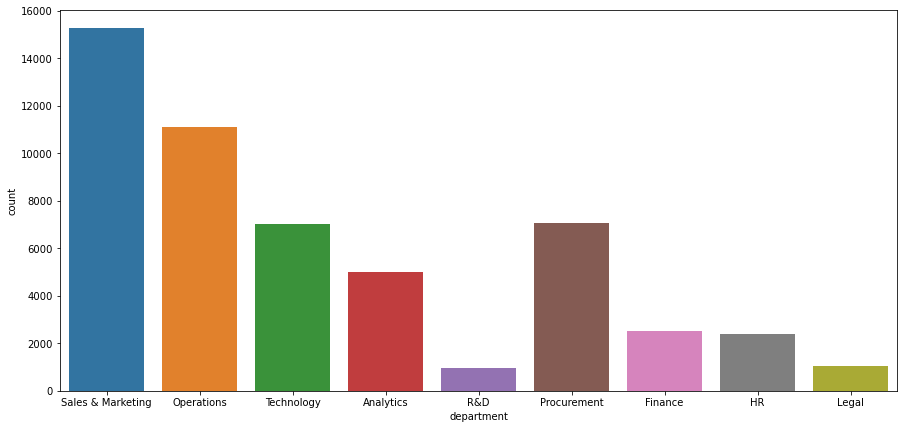

In [40]:
print(df_copy['department'].value_counts())
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['department'])

region_2     11497
region_22     6108
region_7      4624
region_15     2617
region_13     2592
region_26     2160
region_31     1841
region_4      1701
region_27     1575
region_16     1410
region_11     1291
region_28     1234
region_23     1147
region_29      975
region_19      864
region_32      861
region_20      849
region_14      804
region_17      787
region_25      785
region_5       759
region_6       676
region_30      644
region_10      644
region_8       642
region_1       596
region_24      507
region_12      498
region_21      403
region_9       372
region_3       344
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


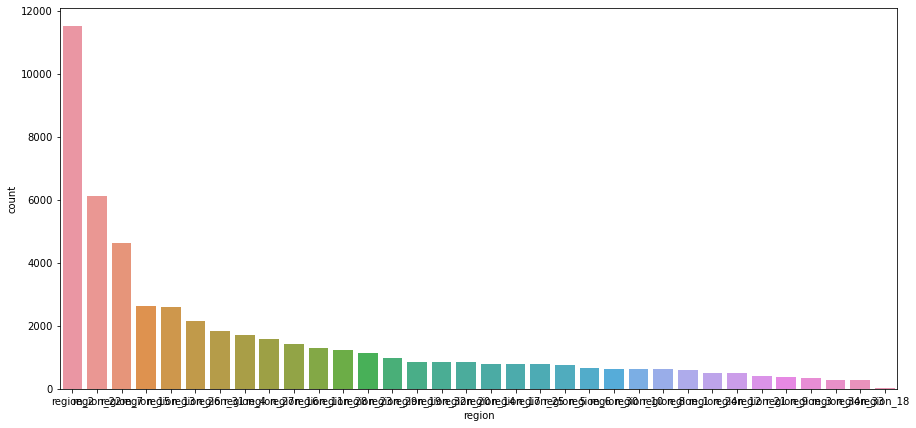

In [44]:
print(df_copy['region'].value_counts(ascending=False))
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['region'], order=df_copy['region'].value_counts(ascending=False).index)

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


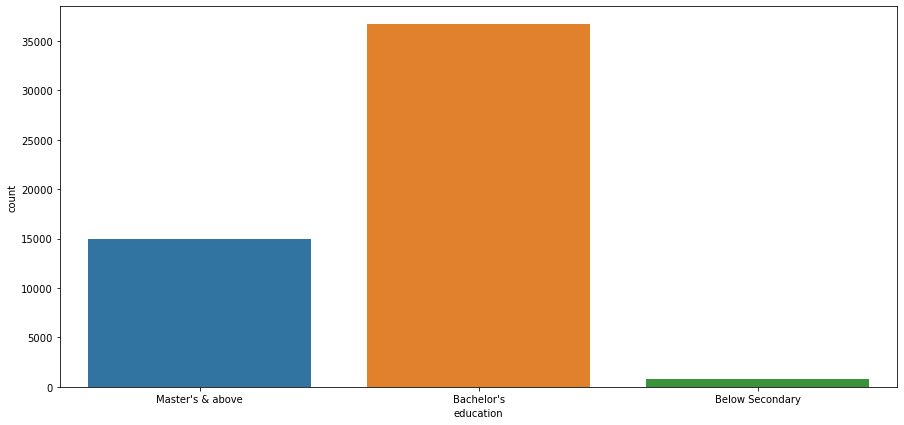

In [42]:
print(df_copy['education'].value_counts())
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['education'])

m    36478
f    15921
Name: gender, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


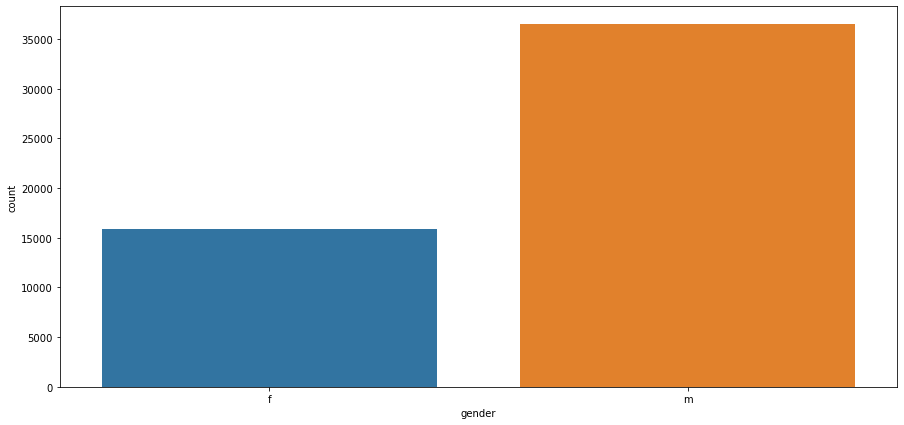

In [45]:
print(df_copy['gender'].value_counts())
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['gender'])

other       29061
sourcing    22204
referred     1134
Name: recruitment_channel, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


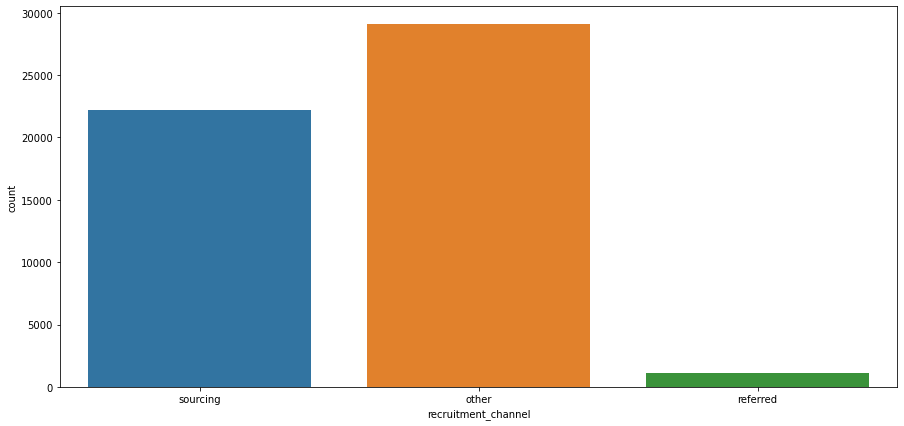

In [46]:
print(df_copy['recruitment_channel'].value_counts())
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['recruitment_channel'])

0    33703
1    18696
Name: KPIs_met >80%, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


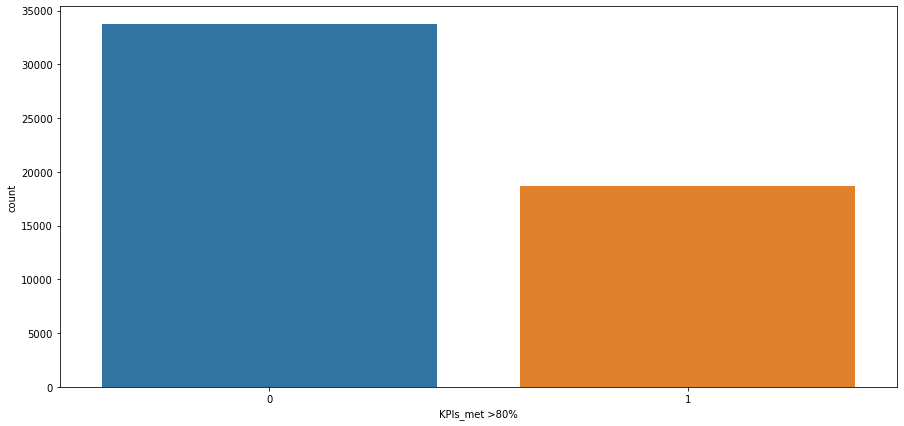

In [47]:
print(df_copy['KPIs_met >80%'].value_counts())
plt.figure(figsize=(15,7))
viz = sns.countplot(df_copy['KPIs_met >80%'])

## Correlation

In [29]:
corr_mtx = df_copy.corr(method='pearson')
corr_mtx

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.082601,-0.062662,-0.057845,-0.047344,-0.007659,0.041124,-0.025389
age,-0.082601,1.000000,0.025439,0.652379,-0.030967,-0.008209,-0.060652,-0.018920
previous_year_rating,-0.062662,0.025439,1.000000,0.021675,0.338513,0.026773,0.066736,0.152921
length_of_service,-0.057845,0.652379,0.021675,1.000000,-0.082109,-0.040140,-0.045329,-0.012167
KPIs_met >80%,-0.047344,-0.030967,0.338513,-0.082109,1.000000,0.095555,0.072899,0.219934
awards_won?,-0.007659,-0.008209,0.026773,-0.040140,0.095555,1.000000,0.072069,0.195451
avg_training_score,0.041124,-0.060652,0.066736,-0.045329,0.072899,0.072069,1.000000,0.180489
is_promoted,-0.025389,-0.018920,0.152921,-0.012167,0.219934,0.195451,0.180489,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

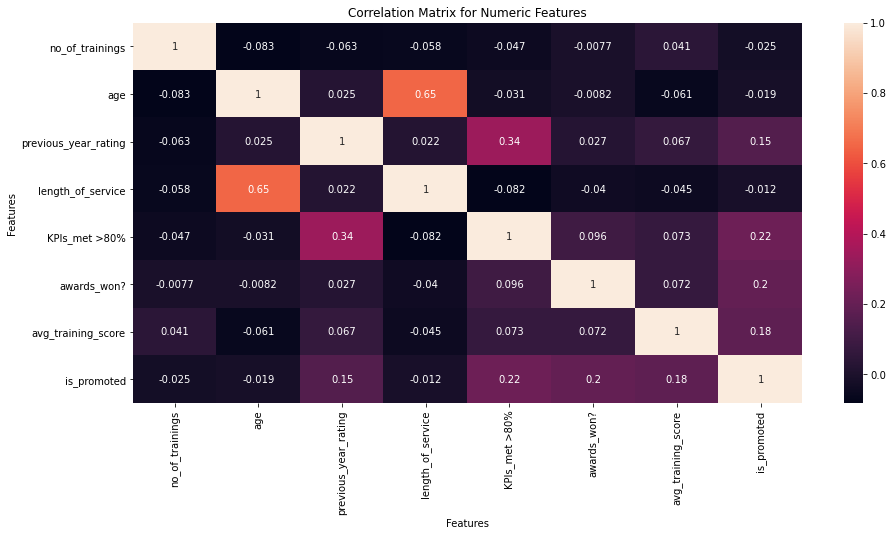

In [38]:
# Plot the Pearson correlation matrix using heatmap

plt.figure(figsize=(15,7))
sns.heatmap(corr_mtx, annot = True)
plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show

In [32]:
# Numerized the object columns

df_num = df_copy.copy()

for col_name in df_numerized.columns:
    if(df_num[col_name].dtype == 'object'):
        df_num[col_name] = df_num[col_name].astype('category')
        df_num[col_name] = df_num[col_name].cat.codes
        
df_num

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7,31,2,0,2,1,35,5.0,8,1,0,49,0
1,4,14,0,1,0,1,30,5.0,4,0,0,60,0
2,7,10,0,1,2,1,34,3.0,7,0,0,50,0
3,7,15,0,1,0,2,39,1.0,10,0,0,50,0
4,8,18,0,1,0,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,7,5,0,1,0,2,31,1.0,2,0,0,49,0
54803,8,5,0,1,2,1,48,3.0,17,0,0,78,0
54804,4,19,2,0,0,1,37,2.0,6,0,0,56,0
54805,0,0,0,1,0,1,27,5.0,3,1,0,79,0


<function matplotlib.pyplot.show(close=None, block=None)>

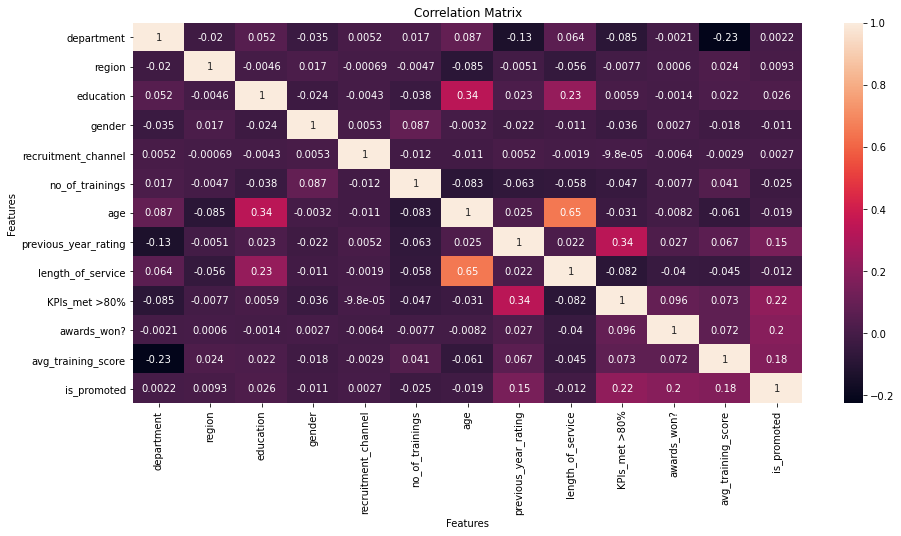

In [39]:
# Pearson correlation matrix heatmap

corr_mtx2 = df_num.corr(method='pearson')

plt.figure(figsize=(15,7))
sns.heatmap(corr_mtx2, annot = True)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show

In [34]:
# Look the correlation between feature

corr_pairs = corr_mtx2.unstack()
corr_pairs

department   department             1.000000
             region                -0.020111
             education              0.051803
             gender                -0.034746
             recruitment_channel    0.005239
                                      ...   
is_promoted  length_of_service     -0.012167
             KPIs_met >80%          0.219934
             awards_won?            0.195451
             avg_training_score     0.180489
             is_promoted            1.000000
Length: 169, dtype: float64

Apparently, the features with high correlation with **is_promoted** is **previous_year_rating**, **KPIs_met >80%**, **awards_won?**, and **avg_training_score**.

Now, we will see the pair of feature with highest correlation (above 50%).

In [35]:
sorted_pairs = corr_pairs.sort_values()
sorted_pairs

avg_training_score    department             -0.225016
department            avg_training_score     -0.225016
previous_year_rating  department             -0.133083
department            previous_year_rating   -0.133083
age                   region                 -0.085286
                                                ...   
gender                gender                  1.000000
education             education               1.000000
region                region                  1.000000
avg_training_score    avg_training_score      1.000000
is_promoted           is_promoted             1.000000
Length: 169, dtype: float64

In [37]:
# Looking at the pairs with high correlation

high_corr = sorted_pairs[(sorted_pairs) > 0.5]
high_corr

age                   length_of_service       0.652379
length_of_service     age                     0.652379
department            department              1.000000
age                   age                     1.000000
awards_won?           awards_won?             1.000000
KPIs_met >80%         KPIs_met >80%           1.000000
length_of_service     length_of_service       1.000000
previous_year_rating  previous_year_rating    1.000000
no_of_trainings       no_of_trainings         1.000000
recruitment_channel   recruitment_channel     1.000000
gender                gender                  1.000000
education             education               1.000000
region                region                  1.000000
avg_training_score    avg_training_score      1.000000
is_promoted           is_promoted             1.000000
dtype: float64

There are only **age** and **length_of_service** that has a correlation above 50%.